In [119]:
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
from jax import jit, vmap, lax
from math import ceil
from functools import partial

from scipy.stats import linregress
import numpy as np

# from jax import debug


# Update matplotlib parameters for better visualization
matplotlib.rcParams.update({
    'font.size': 14,          # General font size
    'axes.labelsize': 14,     # Axis label size
    'axes.titlesize': 14,     # Title size
    'xtick.labelsize': 14,    # X-tick label size
    'ytick.labelsize': 14,    # Y-tick label size
    'legend.fontsize': 14     # Legend font size
})

# Print available JAX devices
print("Available JAX devices:", jax.devices())

# Interpolation function in 2D

# Obtained here: https://github.com/jax-ml/jax/discussions/10689

@jit
def bispline_interp(xnew,ynew,xp,yp,zp):
    """
    (xnew,ynew): two 1D vector  of same size where to perform predictions  f(xnew[i],ynew[i])
    (xp,yp): original grid points 1D vector
    zp: original values of functions  zp[i,j] = value at xp[i], yp[j]
    """
    
    
    M = 1./16 * jnp.array([[0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, -8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, 16, -40, 32, -8, 0, 0, 0, 0, 0, 0, 0, 0], 
                           [0, 0, 0, 0, -8, 24, -24, 8, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, -8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0], 
                           [4, 0, -4, 0, 0, 0, 0, 0, -4, 0, 4, 0, 0, 0, 0, 0], 
                           [-8, 20, -16, 4, 0, 0, 0, 0, 8, -20, 16, -4, 0, 0, 0, 0],
                           [4, -12, 12, -4, 0, 0, 0, 0, -4, 12, -12, 4, 0, 0, 0, 0],
                           [0, 16, 0, 0, 0, -40, 0, 0, 0, 32, 0, 0, 0, -8, 0, 0], 
                           [-8, 0, 8, 0, 20, 0, -20, 0, -16, 0, 16, 0, 4, 0, -4, 0], 
                           [16, -40, 32, -8, -40, 100, -80, 20, 32, -80, 64, -16, -8, 20, -16, 4], 
                           [-8, 24, -24, 8, 20, -60, 60, -20, -16, 48, -48, 16, 4, -12, 12, -4], 
                           [0, -8, 0, 0, 0, 24, 0, 0, 0, -24, 0, 0, 0, 8, 0, 0], 
                           [4, 0, -4, 0, -12, 0, 12, 0, 12, 0, -12, 0, -4, 0, 4, 0], 
                           [-8, 20, -16, 4, 24, -60, 48, -12, -24, 60, -48, 12, 8, -20, 16, -4], 
                           [4, -12, 12, -4, -12, 36, -36, 12, 12, -36, 36, -12, -4, 12, -12, 4]]
                         )
    
    M1 = jnp.array([[1.,0.,0.,0.],
                    [-1.,1.,0.,0.],
                    [-1.,0.,1.,0.],
                    [1.,-1.,-1.,1.]])

    def built_Ivec(zp,ix,iy):
        return jnp.array([zp[ix+i,iy+j] for j in range(-1,3) for i in range(-1,3)])


    def built_Ivec1(zp,ix,iy):
        return jnp.array([zp[ix+i,iy+j] for j in range(0,2) for i in range(0,2)])

    
    
    def compute_basis(x,order=3):
        """
        x in [0,1]
        """ 
        return jnp.array([x**i for i in jnp.arange(0, order+1)])
    
    def tval(xnew,ix,xp):
        return (xnew-xp[ix-1])/(xp[ix]-xp[ix-1])
    
    ix = jnp.clip(jnp.searchsorted(xp, xnew, side="right"), 0, len(xp)-1)
    iy = jnp.clip(jnp.searchsorted(yp, ynew, side="right"), 0, len(yp)-1)

    def bilinear_interp(ix,iy):
        Iv = built_Ivec1(zp,ix-1,iy-1)
        av = M1 @ Iv
        amtx = av.reshape(2,2,-1)
        tx = tval(xnew,ix,xp)
        ty = tval(ynew,iy,yp)
        basis_x = compute_basis(tx,order=1)
        basis_y = compute_basis(ty,order=1)
        res = jnp.einsum("i...,ij...,j...",basis_y,amtx,basis_x)
        return res

    def bispline_interp(ix,iy):
        Iv = built_Ivec(zp,ix-1,iy-1)
        av = M @ Iv
        amtx = av.reshape(4,4,-1)
        tx = tval(xnew,ix,xp)
        ty = tval(ynew,iy,yp)
        basis_x = compute_basis(tx)
        basis_y = compute_basis(ty)
        res = jnp.einsum("i...,ij...,j...",basis_y,amtx,basis_x)
        return res
    
    condx = jnp.logical_and(ix>=2, ix<=len(xp)-2)
    condy = jnp.logical_and(iy>=2, iy<=len(yp)-2)
    
    cond = jnp.logical_and(condx,condy)
    return jnp.where(cond,
             bispline_interp(ix,iy),
             bilinear_interp(ix,iy))


Available JAX devices: [CudaDevice(id=0)]


In [120]:
@jit
def compute_rho(f, dvx, dvy):
    """
    Compute charge density rho from distribution function f in 2D2D setting.
    
    Parameters:
    - f: 4D array of distribution function (shape: [N_x, N_y, N_vx, N_vy]).
    - dvx: Grid spacing in v_x.
    - dvy: Grid spacing in v_y.
    
    Returns:
    - rho: 2D array of charge density (shape: [N_x, N_y]).
    """
    rho = jnp.sum(f, axis=(2, 3)) * dvx * dvy
    return rho

@jit
def compute_Jx(f, grid_vx, grid_vy, dvx, dvy):
    """
    Compute current density J_x by integrating v_x * f over v_x and v_y in 2D2D setting.
    
    Parameters:
    - f: 4D array of distribution function (shape: [N_x, N_y, N_vx, N_vy]).
    - grid_vx: 1D array of v_x coordinates (shape: [N_vx]).
    - grid_vy: 1D array of v_y coordinates (shape: [N_vy]).
    - dvx: Grid spacing in v_x.
    - dvy: Grid spacing in v_y.
    
    Returns:
    - Jx: 2D array of J_x (shape: [N_x, N_y]).
    """
    # Multiply v_x with f: broadcasting grid_vx over x, y, and v_y
    Jx = jnp.sum(grid_vx[None, None, :, None] * f, axis=(2, 3)) * dvx * dvy
    return Jx

@jit
def compute_Jy(f, grid_vx, grid_vy, dvx, dvy):
    """
    Compute current density J_y by integrating v_y * f over v_x and v_y in 2D2D setting.
    
    Parameters:
    - f: 4D array of distribution function (shape: [N_x, N_y, N_vx, N_vy]).
    - grid_vx: 1D array of v_x coordinates (shape: [N_vx]).
    - grid_vy: 1D array of v_y coordinates (shape: [N_vy]).
    - dvx: Grid spacing in v_x.
    - dvy: Grid spacing in v_y.
    
    Returns:
    - Jy: 2D array of J_y (shape: [N_x, N_y]).
    """
    # Multiply v_y with f: broadcasting grid_vy over x, y, and v_x
    Jy = jnp.sum(grid_vy[None, None, None, :] * f, axis=(2, 3)) * dvx * dvy
    return Jy

@jit
def solve_poisson_2d(rho, grid_x, grid_y, dx, dy):
    """
    Solve the 2D Poisson equation ΔU = rho - background in Fourier space to obtain the electric potential U and electric fields E_x, E_y.

    Parameters:
    - rho: 2D array of charge density (shape: [N_x, N_y]).
    - grid_x: 1D array of x-coordinates (shape: [N_x]).
    - grid_y: 1D array of y-coordinates (shape: [N_y]).
    - dx: Grid spacing in x.
    - dy: Grid spacing in y.
    - background: Background charge density to subtract from rho (default: 1.0).

    Returns:
    - U: 2D array of electric potential (shape: [N_x, N_y]).
    - E_x: 2D array of electric field component in x (shape: [N_x, N_y]).
    - E_y: 2D array of electric field component in y (shape: [N_x, N_y]).
    """
    N_x = grid_x.shape[0]
    N_y = grid_y.shape[0]
    
    # Compute Fourier wave numbers for x and y
    kx = jnp.fft.fftfreq(N_x, d=dx) * 2.0 * jnp.pi  # Shape: [N_x]
    ky = jnp.fft.fftfreq(N_y, d=dy) * 2.0 * jnp.pi  # Shape: [N_y]
    
    # Create 2D meshgrid of wave numbers
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')  # Shapes: [N_x, N_y]
    
    K_squared = KX**2 + KY**2  # Shape: [N_x, N_y]
    
    # Subtract background charge density
    rho_minus_background = rho - 1  # ΔU = rho - 1
    
    # Fourier transform of (rho - background)
    rho_hat = jnp.fft.fft2(rho_minus_background)  # Shape: [N_x, N_y]
    
    # Avoid division by zero for the k=0 mode by setting K_squared=1 temporarily
    # We'll set the potential at k=0 to zero later to enforce charge neutrality
    K_squared_no_zero = jnp.where(K_squared == 0, 1.0, K_squared)
    
    # Solve for potential in Fourier space: U_hat = rho_hat / (-K_squared)
    U_hat = rho_hat / (-K_squared_no_zero)
    U_hat = jnp.where(K_squared == 0, 0.0, U_hat)  # Set k=0 mode to zero
    
    # Inverse Fourier transform to get potential in physical space
    U = jnp.fft.ifft2(U_hat).real  # Shape: [N_x, N_y]
    
    # Compute electric field components in Fourier space
    E_hat_x = 1j * KX * U_hat  # Shape: [N_x, N_y]
    E_hat_y = 1j * KY * U_hat  # Shape: [N_x, N_y]
    
    # Inverse Fourier transform to get electric fields in physical space
    E_x = jnp.fft.ifft2(E_hat_x).real  # Shape: [N_x, N_y]
    E_y = jnp.fft.ifft2(E_hat_y).real  # Shape: [N_x, N_y]
    
    return U, E_x, E_y

@jit
def drift_solve(f, grid_x, grid_y, grid_vx, grid_vy, delta_t):
    """
    Solve the drift equation f_t + v_x * f_x + v_y * f_y = 0 using Fourier transforms.
    
    Parameters:
    - f: 4D array of distribution function (shape: [N_x, N_y, N_vx, N_vy]).
    - grid_x: 1D array of x-coordinates (shape: [N_x]).
    - grid_y: 1D array of y-coordinates (shape: [N_y]).
    - grid_vx: 1D array of v_x coordinates (shape: [N_vx]).
    - grid_vy: 1D array of v_y coordinates (shape: [N_vy]).
    - delta_t: Time step for the drift.
    
    Returns:
    - f_next: 4D array of updated distribution function after time delta_t (shape: [N_x, N_y, N_vx, N_vy]).
    """
    # Perform 2D Fourier transform over x and y dimensions
    f_hat = jnp.fft.fft2(f, axes=(0, 1))  # Shape: [N_x, N_y, N_vx, N_vy]
    
    # Compute Fourier wave numbers for x and y
    dx = grid_x[1] - grid_x[0]
    dy = grid_y[1] - grid_y[0]
    kx = jnp.fft.fftfreq(grid_x.size, d=dx) * 2.0 * jnp.pi  # Shape: [N_x]
    ky = jnp.fft.fftfreq(grid_y.size, d=dy) * 2.0 * jnp.pi  # Shape: [N_y]
    
    # Create 2D meshgrid of wave numbers
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')  # Shapes: [N_x, N_y]
    
    # Reshape KX and KY to broadcast with v_x and v_y
    KX = KX[:, :, None, None]  # Shape: [N_x, N_y, 1, 1]
    KY = KY[:, :, None, None]  # Shape: [N_x, N_y, 1, 1]
    
    # Reshape v_x and v_y for broadcasting
    Vx = grid_vx[None, None, :, None]  # Shape: [1, 1, N_vx, 1]
    Vy = grid_vy[None, None, None, :]  # Shape: [1, 1, 1, N_vy]
    
    # Compute the exponential multiplier
    exponent = -1j * (KX * Vx + KY * Vy) * delta_t  # Shape: [N_x, N_y, N_vx, N_vy]
    multiplier = jnp.exp(exponent)  # Shape: [N_x, N_y, N_vx, N_vy]
    
    # Update f_hat with the multiplier
    f_hat_next = f_hat * multiplier  # Shape: [N_x, N_y, N_vx, N_vy]
    
    # Perform inverse 2D Fourier transform to get f_next
    f_next = jnp.fft.ifft2(f_hat_next, axes=(0, 1)).real  # Shape: [N_x, N_y, N_vx, N_vy]
    
    return f_next

@jit
def Hf_update(grid_x, grid_y, grid_vx, grid_vy, f_old, delta_t):
    """
    Update the distribution function by solving the drift equation and updating the electric fields.
    
    Parameters:
    - grid_x: 1D array of x-coordinates (shape: [N_x]).
    - grid_y: 1D array of y-coordinates (shape: [N_y]).
    - grid_vx: 1D array of v_x coordinates (shape: [N_vx]).
    - grid_vy: 1D array of v_y coordinates (shape: [N_vy]).
    - f_old: 4D array of the current distribution function (shape: [N_x, N_y, N_vx, N_vy]).
    - delta_t: Time step for the drift.
    
    Returns:
    - f_new: 4D array of the updated distribution function after time delta_t (shape: [N_x, N_y, N_vx, N_vy]).
    - E_new: Tuple containing:
        - E_x_new: 2D array of the updated electric field component in x (shape: [N_x, N_y]).
        - E_y_new: 2D array of the updated electric field component in y (shape: [N_x, N_y]).
    """
    # Solve the drift equation to get f_new
    f_new = drift_solve(f_old, grid_x, grid_y, grid_vx, grid_vy, delta_t)
    
    # Compute grid spacings
    dvx = grid_vx[1] - grid_vx[0]
    dvy = grid_vy[1] - grid_vy[0]
    dx = grid_x[1] - grid_x[0]
    dy = grid_y[1] - grid_y[0]
    
    # Compute the new charge density rho_new
    rho_new = compute_rho(f_new, dvx, dvy)
    
    # Solve the Poisson equation to get the updated electric fields
    _, E_x_new, E_y_new = solve_poisson_2d(rho_new, grid_x, grid_y, dx, dy)
    
    return f_new, (E_x_new, E_y_new)

from jax import jit, vmap
import jax.numpy as jnp

@jit
def HE_update(grid_vx, grid_vy, f_old, Ex_old, Ey_old, Hx_old, Hy_old, delta_t):
    """
    Solve the HE equation: f_t + (E_x + H_x) ∂_{v_x} f + (E_y + H_y) ∂_{v_y} f = 0
    by shifting f in velocity space based on the total electric fields (E_x + H_x) and (E_y + H_y).

    Parameters:
    - grid_vx: 1D array of v_x coordinates (shape: [N_vx]).
    - grid_vy: 1D array of v_y coordinates (shape: [N_vy}].
    - f_old: 4D array of the current distribution function (shape: [Nx, Ny, N_vx, N_vy}].
    - Ex_old: 2D array of electric field component in x (shape: [Nx, Ny}).
    - Ey_old: 2D array of electric field component in y (shape: [Nx, Ny}].
    - Hx_old: 2D array of external electric field component in x (shape: [Nx, Ny}).
    - Hy_old: 2D array of external electric field component in y (shape: [Nx, Ny}).
    - delta_t: Time step for the update.

    Returns:
    - f_new: 4D array of the updated distribution function after time delta_t (shape: [Nx, Ny, N_vx, N_vy}].
    """
    Nx, Ny, N_vx, N_vy = f_old.shape

    # Reshape spatial dimensions to flat for vectorization
    f_old_flat = f_old.reshape(Nx * Ny, N_vx, N_vy)
    Ex_flat = Ex_old.flatten()
    Ey_flat = Ey_old.flatten()
    Hx_flat = Hx_old.flatten()
    Hy_flat = Hy_old.flatten()

    # Define the per (x,y) shift and interpolation function
    def shift_and_interp(f_xy, Ex_xy, Ey_xy, Hx_xy, Hy_xy):
        # Compute the total electric fields
        total_Ex = Ex_xy + Hx_xy
        total_Ey = Ey_xy + Hy_xy

        # Shift velocities based on total electric fields
        shifted_vx = grid_vx - total_Ex * delta_t
        shifted_vy = grid_vy - total_Ey * delta_t

        # Create meshgrid for shifted velocities
        shifted_vx_grid, shifted_vy_grid = jnp.meshgrid(shifted_vx, shifted_vy, indexing='ij')  # [N_vx, N_vy]

        # Flatten the shifted grids for interpolation
        xnew = shifted_vx_grid.flatten()
        ynew = shifted_vy_grid.flatten()

        # Original grid
        xp = grid_vx
        yp = grid_vy

        # Original distribution function values
        zp = f_xy

        # Perform interpolation using bispline_interp
        # Assuming bispline_interp can handle vectorized inputs
        f_interp_flat = bispline_interp(xnew, ynew, xp, yp, zp)

        # Reshape back to [N_vx, N_vy]
        f_interp = f_interp_flat.reshape(N_vx, N_vy)

        return f_interp

    # Vectorize the shift_and_interp function over all (x,y) points
    vmapped_shift = vmap(shift_and_interp, in_axes=(0, 0, 0, 0, 0))

    # Apply the vectorized shift and interpolation
    f_new_flat = vmapped_shift(f_old_flat, Ex_flat, Ey_flat, Hx_flat, Hy_flat)  # Shape: [Nx*Ny, N_vx, N_vy]

    # Reshape back to [Nx, Ny, N_vx, N_vy]
    f_new = f_new_flat.reshape(Nx, Ny, N_vx, N_vy)

    return f_new


@jit
def compute_kinetic_energy_2D2D(f, grid_vx, grid_vy, dvx, dvy, dx, dy):
    """
    Compute the kinetic energy for a 2D2D distribution function:
        KE = 0.5 * ∫ |v|^2 f(x, y, v_x, v_y) dx dy dv_x dv_y
    
    Parameters:
    - f: 4D array of the distribution function (shape: [N_x, N_y, N_vx, N_vy]).
    - grid_vx: 1D array of v_x coordinates (shape: [N_vx]).
    - grid_vy: 1D array of v_y coordinates (shape: [N_vy]).
    - dvx: Grid spacing in v_x.
    - dvy: Grid spacing in v_y.
    - dx: Grid spacing in x.
    - dy: Grid spacing in y.
    
    Returns:
    - KE: Scalar value representing the total kinetic energy.
    """
    # Create meshgrid for v_x and v_y
    VX, VY = jnp.meshgrid(grid_vx, grid_vy, indexing='ij')  # Shape: [N_vx, N_vy]
    
    # Compute |v|^2 = v_x^2 + v_y^2
    v_squared = VX**2 + VY**2  # Shape: [N_vx, N_vy]
    
    # Expand dimensions to match f's shape: [1, 1, N_vx, N_vy]
    v_squared_expanded = v_squared[None, None, :, :]  # Shape: [1, 1, N_vx, N_vy]
    
    # Compute kinetic energy density: 0.5 * |v|^2 * f
    ke_density = 0.5 * v_squared_expanded * f  # Shape: [N_x, N_y, N_vx, N_vy]
    
    # Integrate over all dimensions: ∫ ke_density dx dy dv_x dv_y
    ke_integrated = jnp.sum(ke_density) * dvx * dvy * dx * dy  # Scalar
    
    return ke_integrated


@jit
def compute_electric_energy_2D2D(E_x, E_y, dx, dy):
    """
    Compute the electric energy for a 2D electric field:
        EE = 0.5 * ∫ (|E_x|^2 + |E_y|^2) dx dy
    
    Parameters:
    - E_x: 2D array of the electric field component in x (shape: [N_x, N_y]).
    - E_y: 2D array of the electric field component in y (shape: [N_x, N_y]).
    - dx: Grid spacing in x.
    - dy: Grid spacing in y.
    
    Returns:
    - EE: Scalar value representing the total electric energy.
    """
    # Compute |E|^2 = E_x^2 + E_y^2
    E_squared = E_x**2 + E_y**2  # Shape: [N_x, N_y]
    
    # Compute electric energy density: 0.5 * |E|^2
    ee_density = 0.5 * E_squared  # Shape: [N_x, N_y]
    
    # Integrate over space: ∫ ee_density dx dy
    ee_integrated = jnp.sum(ee_density) * dx * dy  # Scalar
    
    return ee_integrated


In [121]:
@partial(jit, static_argnums=(6, 7))
def run_solver(f_iv, grid_x, grid_y, grid_vx, grid_vy, delta_t, N_steps, k_track, Hx, Hy):
    """
    Solve the Vlasov-Poisson system using Strang splitting for a 2D2D setting,
    incorporating external electric fields Hx and Hy.

    The solver evolves the distribution function `f_iv` over `N_steps` time steps,
    updating the electric fields `E_x` and `E_y` at each step. It records the history
    of electric fields, kinetic energy, electric energy, and specific Fourier modes.

    Parameters:
    - f_iv: 4D array of the initial distribution function (shape: [N_x, N_y, N_vx, N_vy]).
    - grid_x: 1D array of x-coordinates (shape: [N_x]).
    - grid_y: 1D array of y-coordinates (shape: [N_y]).
    - grid_vx: 1D array of v_x coordinates (shape: [N_vx]).
    - grid_vy: 1D array of v_y coordinates (shape: [N_vy]).
    - delta_t: Time step for each update.
    - N_steps: Number of time steps to evolve.
    - k_track: Tuple (k, m) indicating the Fourier mode to track for E_x and E_y.
    - Hx: 2D array of external electric field component in x (shape: [N_x, N_y]).
    - Hy: 2D array of external electric field component in y (shape: [N_x, N_y]).

    Returns:
    - f_final: 4D array of the distribution function after `N_steps` (shape: [N_x, N_y, N_vx, N_vy]).
    - history_E: 4D array of electric fields over time (shape: [N_steps + 1, N_x, N_y, 2]).
                The last dimension corresponds to (E_x, E_y).
    - history_KE: 1D array of kinetic energy at each time step (shape: [N_steps + 1]).
    - history_EE: 1D array of electric energy at each time step (shape: [N_steps + 1]).
    - history_Fourier: 2D array of tracked Fourier modes for E_x and E_y over time (shape: [N_steps + 1, 2]).
                         The last dimension corresponds to (E_x_hat[k, m], E_y_hat[k, m]).
    """
    # Compute grid spacings
    dx = grid_x[1] - grid_x[0]
    dy = grid_y[1] - grid_y[0]
    dvx = grid_vx[1] - grid_vx[0]
    dvy = grid_vy[1] - grid_vy[0]

    # Extract Fourier mode indices
    k, m = k_track

    # Initial charge density
    rho = compute_rho(f_iv, dvx, dvy)  # Shape: [N_x, N_y]

    # Solve Poisson equation to get initial electric fields
    _, E_x, E_y = solve_poisson_2d(rho, grid_x, grid_y, dx, dy)  # Each Shape: [N_x, N_y]

    # Compute initial kinetic and electric energies
    KE = compute_kinetic_energy_2D2D(f_iv, grid_vx, grid_vy, dvx, dvy, dx, dy)  # Scalar
    EE = compute_electric_energy_2D2D(E_x, E_y, dx, dy)  # Scalar

    # Compute initial Fourier transforms of electric fields
    E_x_hat = jnp.fft.fft2(E_x)  # Shape: [N_x, N_y]
    E_y_hat = jnp.fft.fft2(E_y)  # Shape: [N_x, N_y]

    # Extract the specified Fourier modes
    E_x_mode = E_x_hat[k, m]  # Scalar (complex)
    E_y_mode = E_y_hat[k, m]  # Scalar (complex)

    # Initialize histories with the initial step
    history_E_initial = jnp.stack([E_x, E_y], axis=-1)[None, ...]  # Shape: [1, N_x, N_y, 2]
    history_KE_initial = jnp.array([KE])  # Shape: [1]
    history_EE_initial = jnp.array([EE])  # Shape: [1]
    history_Fourier_initial = jnp.stack([E_x_mode, E_y_mode], axis=-1)[None, ...]  # Shape: [1, 2]

    # Define the step function for Strang splitting
    def step_fn(carry, _):
        """
        Perform one Strang splitting step.

        Parameters:
        - carry: Tuple containing the current distribution function and electric fields.
                 (f_current, E_x_old, E_y_old)
        - _: Placeholder for the loop index (unused).

        Returns:
        - new_carry: Updated carry tuple (f_new, E_x_new, E_y_new).
        - output: Tuple containing the updated electric fields, kinetic energy, electric energy,
                  and tracked Fourier modes.
        """
        f_current, E_x_old, E_y_old = carry  # Unpack the carry

        # Step 1: Hf_update with delta_t / 2
        # Hf_update returns (f_half, (E_x_half, E_y_half))
        f_half, (E_x_half, E_y_half) = Hf_update(
            grid_x, grid_y, grid_vx, grid_vy, f_current, delta_t / 2
        )  # Shape: [N_x, N_y, N_vx, N_vy], (N_x, N_y)

        # Step 2: HE_update with delta_t, including external fields Hx and Hy
        f_middle = HE_update(
            grid_vx, grid_vy, f_half, E_x_half, E_y_half, Hx, Hy, delta_t
        )  # Shape: [N_x, N_y, N_vx, N_vy]

        # Step 3: Hf_update with delta_t / 2
        # Hf_update returns (f_new, (E_x_new, E_y_new))
        f_new, (E_x_new, E_y_new) = Hf_update(
            grid_x, grid_y, grid_vx, grid_vy, f_middle, delta_t / 2
        )  # Shape: [N_x, N_y, N_vx, N_vy], (N_x, N_y)

        # Compute new charge density
        rho_new = compute_rho(f_new, dvx, dvy)  # Shape: [N_x, N_y]

        # Solve Poisson equation to get updated electric fields
        # **Note:** If `Hf_update` already computes electric fields, this step might be redundant.
        # Uncomment the next line if additional Poisson solving is necessary.
        # _, E_x_new, E_y_new = solve_poisson_2d(rho_new, grid_x, grid_y, dx, dy)

        # Compute kinetic and electric energies
        KE_new = compute_kinetic_energy_2D2D(
            f_new, grid_vx, grid_vy, dvx, dvy, dx, dy
        )  # Scalar
        EE_new = compute_electric_energy_2D2D(
            E_x_new, E_y_new, dx, dy
        )  # Scalar

        # Compute Fourier transforms of updated electric fields
        E_x_hat_new = jnp.fft.fft2(E_x_new)  # Shape: [N_x, N_y]
        E_y_hat_new = jnp.fft.fft2(E_y_new)  # Shape: [N_x, N_y]

        # Extract the specified Fourier modes
        E_x_mode_new = E_x_hat_new[k, m]  # Scalar (complex)
        E_y_mode_new = E_y_hat_new[k, m]  # Scalar (complex)

        # Stack tracked Fourier modes
        Fourier_new = jnp.stack([E_x_mode_new, E_y_mode_new], axis=-1)  # Shape: [2]

        # Stack updated electric fields
        E_new = jnp.stack([E_x_new, E_y_new], axis=-1)  # Shape: [N_x, N_y, 2]

        # Update the carry
        new_carry = (f_new, E_x_new, E_y_new)

        # Package the outputs
        output = (E_new, KE_new, EE_new, Fourier_new)

        return new_carry, output

    # Initialize the carry with the current f and electric fields
    carry_init = (f_iv, E_x, E_y)  # Tuple: (f_current, E_x_current, E_y_current)

    # Perform Strang splitting over N_steps using lax.scan
    f_final, scan_outputs = lax.scan(step_fn, carry_init, None, length=N_steps)

    # Unpack scan outputs
    E_new_steps, KE_steps, EE_steps, Fourier_steps = scan_outputs  # Each shape: [N_steps, ...]

    # Stack initial histories with scan step histories
    # Electric fields history: [1 + N_steps, N_x, N_y, 2]
    history_E_steps = E_new_steps  # Shape: [N_steps, N_x, N_y, 2]
    history_E_total = jnp.concatenate(
        [history_E_initial, history_E_steps], axis=0
    )  # Shape: [1 + N_steps, N_x, N_y, 2]

    # Kinetic energy history: [1 + N_steps]
    history_KE_steps = KE_steps  # Shape: [N_steps]
    history_KE_total = jnp.concatenate(
        [history_KE_initial, history_KE_steps], axis=0
    )  # Shape: [1 + N_steps]

    # Electric energy history: [1 + N_steps]
    history_EE_steps = EE_steps  # Shape: [N_steps]
    history_EE_total = jnp.concatenate(
        [history_EE_initial, history_EE_steps], axis=0
    )  # Shape: [1 + N_steps]

    # Fourier modes history: [1 + N_steps, 2]
    history_Fourier_steps = Fourier_steps  # Shape: [N_steps, 2]
    history_Fourier_total = jnp.concatenate(
        [history_Fourier_initial, history_Fourier_steps], axis=0
    )  # Shape: [1 + N_steps, 2]

    # Return the final distribution function and all histories
    return (
        f_final,
        history_E_total,
        history_KE_total,
        history_EE_total,
        history_Fourier_total,
    )


In [99]:
# def test_compute_rho(Nx=200, Ny=200, Nvx=100, Nvy=100, alpha=0.05, beta=0.03):
#     # Define spatial and velocity grids
#     x = jnp.linspace(0, 2*jnp.pi, Nx, endpoint=False)
#     y = jnp.linspace(0, 2*jnp.pi, Ny, endpoint=False)
#     vx = jnp.linspace(-5, 5, Nvx)
#     vy = jnp.linspace(-5, 5, Nvy)
#     dvx = vx[1] - vx[0]
#     dvy = vy[1] - vy[0]
    
#     # Create meshgrids for x, y, vx, vy
#     X, Y = jnp.meshgrid(x, y, indexing='ij')       # Shape: (Nx, Ny)
#     VX, VY = jnp.meshgrid(vx, vy, indexing='ij')   # Shape: (Nvx, Nvy)
    
#     # Expand dimensions to broadcast correctly
#     X_expanded = X[:, :, None, None]               # Shape: (Nx, Ny, 1, 1)
#     Y_expanded = Y[:, :, None, None]               # Shape: (Nx, Ny, 1, 1)
#     VX_expanded = VX[None, None, :, :]             # Shape: (1, 1, Nvx, Nvy)
#     VY_expanded = VY[None, None, :, :]             # Shape: (1, 1, Nvx, Nvy)
    
#     # Define the distribution function f
#     f = (1 / (2 * jnp.pi)) * jnp.exp(-VX_expanded**2 / 2 - VY_expanded**2 / 2) \
#         * (1 + alpha * jnp.sin(X_expanded) + beta * jnp.sin(Y_expanded))
    
#     # Compute numerical rho
#     rho_numerical = compute_rho(f, dvx, dvy)
    
#     # Define analytical rho
#     rho_analytical = 1 + alpha * jnp.sin(x)[:, None] + beta * jnp.sin(y)[None, :]
    
#     # Compute L2 error
#     error = jnp.sqrt(jnp.sum((rho_numerical - rho_analytical)**2) / jnp.sum(rho_analytical**2))
    
#     # Convert to numpy for plotting
#     rho_num_np = np.array(rho_numerical)
#     rho_an_np = np.array(rho_analytical)
    
#     # Plotting
#     plt.figure(figsize=(18, 5))
    
#     plt.subplot(1, 3, 1)
#     plt.title('Numerical rho')
#     plt.pcolormesh(x, y, rho_num_np.T, shading='auto', cmap='viridis')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.subplot(1, 3, 2)
#     plt.title('Analytical rho')
#     plt.pcolormesh(x, y, rho_an_np.T, shading='auto', cmap='viridis')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.subplot(1, 3, 3)
#     plt.title(f'Error: L2 = {error:.2e}')
#     plt.pcolormesh(x, y, (rho_num_np - rho_an_np).T, shading='auto', cmap='bwr')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()
    
#     print(f"L2 Error: {error:.6e}")

# if __name__ == "__main__":
#     test_compute_rho()

In [100]:
# def test_solve_poisson_2d(Nx=256, Ny=256, alpha=1000.0, beta=0.3, kx_val=8.0, ky_val=1.0):
#     """
#     Test the 2D Poisson solver with a known analytical solution.

#     Analytical solution:
#         rho = 1 + alpha * kx^2 * cos(kx * x) + beta * ky^2 * sin(ky * y)
#         U = -alpha * cos(kx * x) - beta * sin(ky * y)
#         E_x = alpha * kx * sin(kx * x)
#         E_y = -beta * ky * cos(ky * y)
#     """
#     # Define spatial grids
#     Lx = 2.0 * jnp.pi
#     Ly = 2.0 * jnp.pi
#     x = jnp.linspace(0, Lx, Nx, endpoint=False)
#     y = jnp.linspace(0, Ly, Ny, endpoint=False)
#     dx = x[1] - x[0]
#     dy = y[1] - y[0]
    
#     # Create 2D meshgrid for spatial coordinates
#     X, Y = jnp.meshgrid(x, y, indexing='ij')  # Shapes: [N_x, N_y]
    
#     # Define wave numbers for the test
#     kx_wave = kx_val  # e.g., 1.0
#     ky_wave = ky_val  # e.g., 1.0
    
#     # Define the charge density rho
#     rho = 1 + alpha * kx_wave**2 * jnp.cos(kx_wave * X) + beta * ky_wave**2 * jnp.sin(ky_wave * Y)
    
#     # Solve Poisson equation
#     U_num, E_x_num, E_y_num = solve_poisson_2d(rho, x, y, dx, dy)
    
#     # Define analytical solutions
#     U_analytical = -alpha * jnp.cos(kx_wave * X) - beta * jnp.sin(ky_wave * Y)
#     E_x_analytical = alpha * kx_wave * jnp.sin(kx_wave * X)
#     E_y_analytical = -beta * ky_wave * jnp.cos(ky_wave * Y)
    
#     # Compute L2 errors
#     error_U = jnp.sqrt(jnp.sum((U_num - U_analytical)**2) / jnp.sum(U_analytical**2))
#     error_E_x = jnp.sqrt(jnp.sum((E_x_num - E_x_analytical)**2) / jnp.sum(E_x_analytical**2))
#     error_E_y = jnp.sqrt(jnp.sum((E_y_num - E_y_analytical)**2) / jnp.sum(E_y_analytical**2))
    
#     # Convert to numpy for plotting
#     U_num_np = np.array(U_num)
#     U_an_np = np.array(U_analytical)
#     E_x_num_np = np.array(E_x_num)
#     E_x_an_np = np.array(E_x_analytical)
#     E_y_num_np = np.array(E_y_num)
#     E_y_an_np = np.array(E_y_analytical)
    
#     # Plotting
#     fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
#     # Plot Potential U
#     im0 = axes[0, 0].pcolormesh(x, y, U_num_np.T, shading='auto', cmap='viridis')
#     axes[0, 0].set_title('Numerical Potential U')
#     axes[0, 0].set_xlabel('x')
#     axes[0, 0].set_ylabel('y')
#     fig.colorbar(im0, ax=axes[0, 0])
    
#     im1 = axes[0, 1].pcolormesh(x, y, U_an_np.T, shading='auto', cmap='viridis')
#     axes[0, 1].set_title('Analytical Potential U')
#     axes[0, 1].set_xlabel('x')
#     axes[0, 1].set_ylabel('y')
#     fig.colorbar(im1, ax=axes[0, 1])
    
#     im2 = axes[0, 2].pcolormesh(x, y, (U_num_np - U_an_np).T, shading='auto', cmap='bwr')
#     axes[0, 2].set_title(f'U Error: L2 = {error_U:.2e}')
#     axes[0, 2].set_xlabel('x')
#     axes[0, 2].set_ylabel('y')
#     fig.colorbar(im2, ax=axes[0, 2])
    
#     # Plot Electric Field E_x
#     im3 = axes[1, 0].pcolormesh(x, y, E_x_num_np.T, shading='auto', cmap='viridis')
#     axes[1, 0].set_title('Numerical Electric Field E_x')
#     axes[1, 0].set_xlabel('x')
#     axes[1, 0].set_ylabel('y')
#     fig.colorbar(im3, ax=axes[1, 0])
    
#     im4 = axes[1, 1].pcolormesh(x, y, E_x_an_np.T, shading='auto', cmap='viridis')
#     axes[1, 1].set_title('Analytical Electric Field E_x')
#     axes[1, 1].set_xlabel('x')
#     axes[1, 1].set_ylabel('y')
#     fig.colorbar(im4, ax=axes[1, 1])
    
#     im5 = axes[1, 2].pcolormesh(x, y, (E_x_num_np - E_x_an_np).T, shading='auto', cmap='bwr')
#     axes[1, 2].set_title(f'E_x Error: L2 = {error_E_x:.2e}')
#     axes[1, 2].set_xlabel('x')
#     axes[1, 2].set_ylabel('y')
#     fig.colorbar(im5, ax=axes[1, 2])
    
#     # Plot Electric Field E_y
#     im6 = axes[2, 0].pcolormesh(x, y, E_y_num_np.T, shading='auto', cmap='viridis')
#     axes[2, 0].set_title('Numerical Electric Field E_y')
#     axes[2, 0].set_xlabel('x')
#     axes[2, 0].set_ylabel('y')
#     fig.colorbar(im6, ax=axes[2, 0])
    
#     im7 = axes[2, 1].pcolormesh(x, y, E_y_an_np.T, shading='auto', cmap='viridis')
#     axes[2, 1].set_title('Analytical Electric Field E_y')
#     axes[2, 1].set_xlabel('x')
#     axes[2, 1].set_ylabel('y')
#     fig.colorbar(im7, ax=axes[2, 1])
    
#     im8 = axes[2, 2].pcolormesh(x, y, (E_y_num_np - E_y_an_np).T, shading='auto', cmap='bwr')
#     axes[2, 2].set_title(f'E_y Error: L2 = {error_E_y:.2e}')
#     axes[2, 2].set_xlabel('x')
#     axes[2, 2].set_ylabel('y')
#     fig.colorbar(im8, ax=axes[2, 2])
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print L2 Errors
#     print(f"L2 Error in Potential U: {error_U:.6e}")
#     print(f"L2 Error in Electric Field E_x: {error_E_x:.6e}")
#     print(f"L2 Error in Electric Field E_y: {error_E_y:.6e}")

# if __name__ == "__main__":
#     test_solve_poisson_2d()

In [101]:
# def test_drift_solve(Nx=32, Ny=32, Nvx=32, Nvy=32, alpha=0.5, beta=0.3, delta_t=0.1):
#     """
#     Test the drift_solve function with an analytical solution.

#     Analytical solution:
#         f_analytical(x, y, v_x, v_y, t) = (1/(2π)) * exp(-v_x^2/2 - v_y^2/2) * (1 + alpha * cos(x - v_x * t) + beta * sin(y - v_y * t))

#     Parameters:
#     - Nx: Number of grid points in x.
#     - Ny: Number of grid points in y.
#     - Nvx: Number of grid points in v_x.
#     - Nvy: Number of grid points in v_y.
#     - alpha: Amplitude of the cosine perturbation in x.
#     - beta: Amplitude of the sine perturbation in y.
#     - delta_t: Time step for the drift.
#     """
#     import matplotlib.pyplot as plt
#     import jax.numpy as jnp
    
#     # Define spatial and velocity grids
#     Lx = 2.0 * jnp.pi
#     Ly = 2.0 * jnp.pi
#     x = jnp.linspace(0, Lx, Nx, endpoint=False)
#     y = jnp.linspace(0, Ly, Ny, endpoint=False)
#     vx = jnp.linspace(-5, 5, Nvx)
#     vy = jnp.linspace(-5, 5, Nvy)

#     # Create meshgrids for x, y, v_x, v_y
#     X, Y = jnp.meshgrid(x, y, indexing='ij')       # Shapes: [Nx, Ny]
#     VX, VY = jnp.meshgrid(vx, vy, indexing='ij')   # Shapes: [Nvx, Nvy]

#     # Expand dimensions to broadcast correctly
#     X_expanded = X[:, :, None, None]               # Shape: [Nx, Ny, 1, 1]
#     Y_expanded = Y[:, :, None, None]               # Shape: [Nx, Ny, 1, 1]
#     VX_expanded = VX[None, None, :, :]             # Shape: [1, 1, Nvx, Nvy]
#     VY_expanded = VY[None, None, :, :]             # Shape: [1, 1, Nvx, Nvy]

#     # Define the initial distribution function f_initial
#     f_initial = (1 / (2 * jnp.pi)) * jnp.exp(-VX_expanded**2 / 2 - VY_expanded**2 / 2) \
#                 * (1 + alpha * jnp.cos(X_expanded) + beta * jnp.sin(Y_expanded))

#     # Perform the drift step
#     f_numerical = drift_solve(f_initial, x, y, vx, vy, delta_t)

#     # Define the analytical solution after drift
#     f_analytical = (1 / (2 * jnp.pi)) * jnp.exp(-VX_expanded**2 / 2 - VY_expanded**2 / 2) \
#                    * (1 + alpha * jnp.cos(X_expanded - VX_expanded * delta_t) + beta * jnp.sin(Y_expanded - VY_expanded * delta_t))

#     # Compute the L2 error
#     error = jnp.sqrt(jnp.sum((f_numerical - f_analytical)**2) / jnp.sum(f_analytical**2))

#     # Choose specific v_x and v_y for 2D plots
#     idx_vx = Nvx // 2 - 1  # Center index for v_x
#     idx_vy = Nvy // 2 - 1 # Center index for v_y

#     selected_vx = vx[idx_vx]
#     selected_vy = vy[idx_vy]

#     # Extract 2D slices for the selected v_x and v_y
#     f_numerical_slice = jnp.array(f_numerical[:, :, idx_vx, idx_vy])
#     f_analytical_slice = jnp.array(f_analytical[:, :, idx_vx, idx_vy])
#     error_slice = f_numerical_slice - f_analytical_slice

#     # Plot the numerical solution
#     plt.figure(figsize=(18, 6))

#     plt.subplot(1, 3, 1)
#     plt.title(f'Numerical Solution (v_x = {selected_vx:.2f}, v_y = {selected_vy:.2f})')
#     plt.contourf(x, y, f_numerical_slice.T, levels=50, cmap='viridis')
#     plt.colorbar(label='f')
#     plt.xlabel('x')
#     plt.ylabel('y')

#     # Plot the analytical solution
#     plt.subplot(1, 3, 2)
#     plt.title(f'Analytical Solution (v_x = {selected_vx:.2f}, v_y = {selected_vy:.2f})')
#     plt.contourf(x, y, f_analytical_slice.T, levels=50, cmap='viridis')
#     plt.colorbar(label='f')
#     plt.xlabel('x')
#     plt.ylabel('y')

#     # Plot the error
#     plt.subplot(1, 3, 3)
#     plt.title(f'Difference (Numerical - Analytical)')
#     plt.contourf(x, y, error_slice.T, levels=50, cmap='coolwarm')
#     plt.colorbar(label='Error')
#     plt.xlabel('x')
#     plt.ylabel('y')

#     plt.tight_layout()
#     plt.show()

#     # Print the L2 error
#     print(f"L2 Error between numerical and analytical solutions: {error:.6e}")

# if __name__ == "__main__":
#     test_drift_solve()


In [102]:
# def test_Hf_update(Nx=32, Ny=32, Nvx=128, Nvy=128, alpha=0.5, beta=0.3, delta_t=2, Vx=1.0, Vy=1.0):
#     """
#     Test the Hf_update function by comparing numerical and analytical electric fields after a drift step.
    
#     Parameters:
#     - Nx: Number of grid points in x.
#     - Ny: Number of grid points in y.
#     - Nvx: Number of grid points in v_x.
#     - Nvy: Number of grid points in v_y.
#     - alpha: Amplitude of the cosine perturbation in x.
#     - beta: Amplitude of the cosine perturbation in y.
#     - delta_t: Time step for the drift.
#     - Vx: Maximum velocity in x (range for v_x is [-Vx, Vx]).
#     - Vy: Maximum velocity in y (range for v_y is [-Vy, Vy]).
#     """
#     # Define spatial and velocity grids
#     Lx = 2.0 * jnp.pi
#     Ly = 2.0 * jnp.pi
#     x = jnp.linspace(0, Lx, Nx, endpoint=False)
#     y = jnp.linspace(0, Ly, Ny, endpoint=False)
#     vx = jnp.linspace(-Vx, Vx, Nvx)
#     vy = jnp.linspace(-Vy, Vy, Nvy)
    
#     # Compute grid spacings
#     dx = x[1] - x[0]
#     dy = y[1] - y[0]
#     dvx = vx[1] - vx[0]
#     dvy = vy[1] - vy[0]
    
#     # Create meshgrids for spatial and velocity coordinates
#     X, Y = jnp.meshgrid(x, y, indexing='ij')       # Shapes: [Nx, Ny]
#     VX, VY = jnp.meshgrid(vx, vy, indexing='ij')   # Shapes: [Nvx, Nvy]
    
#     # Expand dimensions to broadcast correctly
#     X_expanded = X[:, :, None, None]               # Shape: [Nx, Ny, 1, 1]
#     Y_expanded = Y[:, :, None, None]               # Shape: [Nx, Ny, 1, 1]
#     VX_expanded = VX[None, None, :, :]             # Shape: [1, 1, Nvx, Nvy]
#     VY_expanded = VY[None, None, :, :]             # Shape: [1, 1, Nvx, Nvy]
    
#     # Calculate normalization constant Z
#     Z = 4.0 * Vx * Vy  # Z = ∫∫1 dvx dvy = 4 Vx Vy
    
#     # Define the initial distribution function f_old
#     f_old = (1 / Z) * (1 + alpha * jnp.cos(X_expanded)) * (1 + beta * jnp.cos(Y_expanded))
    
#     # Perform the update step
#     f_new, E_new = Hf_update(x, y, vx, vy, f_old, delta_t)
#     E_x_new, E_y_new = E_new
    
#     # Define the analytical solution after drift
#     f_analytical = (1 / Z) * (1 + alpha * jnp.cos(X_expanded - VX_expanded * delta_t)) \
#                    * (1 + beta * jnp.cos(Y_expanded - VY_expanded * delta_t))
    
#     # Compute rho_numerical using compute_rho
#     rho_numerical = compute_rho(f_new, dvx, dvy)  # Shape: [Nx, Ny]
    
#     # Compute rho_analytical by integrating f_analytical over velocities
#     # rho_analytical(x, y) = 1/Z * [2 Vx + alpha / delta_t (sin(x + Vx delta_t) - sin(x - Vx delta_t)) ] \
#     #                          [2 Vy + beta / delta_t (sin(y + Vy delta_t) - sin(y - Vy delta_t)) ]
    
#     rho_analytical = (1 / Z) * (2.0 * Vx + (alpha / delta_t) * 
#                                  (jnp.sin(X - (-Vx * delta_t)) - jnp.sin(X - (Vx * delta_t)))) \
#                                 * (2.0 * Vy + (beta / delta_t) * 
#                                    (jnp.sin(Y - (-Vy * delta_t)) - jnp.sin(Y - (Vy * delta_t))))
    
#     # Compute E_analytical by solving Poisson equation with rho_analytical
#     _, E_x_analytical, E_y_analytical = solve_poisson_2d(rho_analytical, x, y, dx, dy)
    
#     # Compute L2 errors between numerical and analytical electric fields
#     error_E_x = jnp.sqrt(jnp.sum((E_x_new - E_x_analytical)**2) / jnp.sum(E_x_analytical**2))
#     error_E_y = jnp.sqrt(jnp.sum((E_y_new - E_y_analytical)**2) / jnp.sum(E_y_analytical**2))
    
#     # Convert JAX arrays to NumPy for plotting
#     E_x_new_np = np.array(E_x_new)
#     E_x_analytical_np = np.array(E_x_analytical)
#     E_y_new_np = np.array(E_y_new)
#     E_y_analytical_np = np.array(E_y_analytical)
    
#     # Plotting Electric Fields E_x
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.title('Numerical Electric Field E_x')
#     plt.pcolormesh(x, y, E_x_new_np.T, shading='auto', cmap='viridis')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.subplot(1, 2, 2)
#     plt.title('Analytical Electric Field E_x')
#     plt.pcolormesh(x, y, E_x_analytical_np.T, shading='auto', cmap='viridis')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()
    
#     # Plotting Electric Fields E_y
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.title('Numerical Electric Field E_y')
#     plt.pcolormesh(x, y, E_y_new_np.T, shading='auto', cmap='viridis')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.subplot(1, 2, 2)
#     plt.title('Analytical Electric Field E_y')
#     plt.pcolormesh(x, y, E_y_analytical_np.T, shading='auto', cmap='viridis')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()
    
#     # Compute and plot the L2 differences
#     L2_diff_E_x = jnp.sqrt(jnp.sum((E_x_new - E_x_analytical)**2) / jnp.sum(E_x_analytical**2))
#     L2_diff_E_y = jnp.sqrt(jnp.sum((E_y_new - E_y_analytical)**2) / jnp.sum(E_y_analytical**2))
    
#     print(f"L2 Error in Electric Field E_x: {L2_diff_E_x:.6e}")
#     print(f"L2 Error in Electric Field E_y: {L2_diff_E_y:.6e}")
    
#     # Optional: Plot the differences
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.title('Difference in Electric Field E_x (Numerical - Analytical)')
#     plt.pcolormesh(x, y, (E_x_new_np - E_x_analytical_np).T, shading='auto', cmap='bwr')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.subplot(1, 2, 2)
#     plt.title('Difference in Electric Field E_y (Numerical - Analytical)')
#     plt.pcolormesh(x, y, (E_y_new_np - E_y_analytical_np).T, shading='auto', cmap='bwr')
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()

# if __name__ == "__main__":
#     test_Hf_update()

In [103]:
# import jax.numpy as jnp
# from jax import jit
# import matplotlib.pyplot as plt
# import numpy as np

# # Assume HE_update, compute_rho, solve_poisson_2d, and bispline_interp are already defined and imported

# def test_HE_update():
#     """
#     Test the HE_update function by comparing the numerical solution with the analytical solution.

#     Steps:
#     1. Define grid_x, grid_y, grid_vx, grid_vy.
#     2. Define f_old = (1/(2π)) * exp(-vx^2/2 - vy^2/2) * (1 + alpha cos(x) + beta sin(y)).
#     3. Define E_old = (sin(x), sin(y)).
#     4. Perform HE_update to get f_new.
#     5. Define f_analytical = (1/(2π)) * exp(-(vx - sin(x)delta_t)^2/2 - (vy - sin(y)delta_t)^2/2) * (1 + alpha cos(x) + beta sin(y)).
#     6. Compare f_new and f_analytical for selected x and y by plotting over vx and vy.
#     7. Compute L2 difference over the 4D domain.
#     """
#     # Parameters
#     Nx = 64
#     Ny = 64
#     Nvx = 32
#     Nvy = 32
#     alpha = 0.9
#     beta = 0.9
#     delta_t = 1
#     Vx = 5.0
#     Vy = 5.0

#     # Define spatial and velocity grids
#     Lx = 2.0 * jnp.pi
#     Ly = 2.0 * jnp.pi
#     x = jnp.linspace(0, Lx, Nx, endpoint=False)
#     y = jnp.linspace(0, Ly, Ny, endpoint=False)
#     vx = jnp.linspace(-Vx, Vx, Nvx)
#     vy = jnp.linspace(-Vy, Vy, Nvy)

#     # Compute grid spacings
#     dx = x[1] - x[0]
#     dy = y[1] - y[0]
#     dvx = vx[1] - vx[0]
#     dvy = vy[1] - vy[0]

#     # Create meshgrids for spatial and velocity coordinates
#     X, Y = jnp.meshgrid(x, y, indexing='ij')       # Shape: [Nx, Ny]
#     VX, VY = jnp.meshgrid(vx, vy, indexing='ij')   # Shape: [Nvx, Nvy]

#     # Expand dimensions to broadcast correctly
#     X_expanded = X[:, :, None, None]               # Shape: [Nx, Ny, 1, 1]
#     Y_expanded = Y[:, :, None, None]               # Shape: [Nx, Ny, 1, 1]
#     VX_expanded = VX[None, None, :, :]             # Shape: [1, 1, Nvx, Nvy]
#     VY_expanded = VY[None, None, :, :]             # Shape: [1, 1, Nvx, Nvy]

#     # Calculate normalization constant Z
#     Z = 4.0 * Vx * Vy  # Z = ∫∫1 dvx dvy = 4 Vx Vy

#     # Define the initial distribution function f_old
#     f_old = (1 / (2 * jnp.pi)) * jnp.exp(-VX_expanded**2 / 2 - VY_expanded**2 / 2) \
#             * (1 + alpha * jnp.cos(X_expanded) + beta * jnp.sin(Y_expanded))

#     # Define E_old
#     Ex_old = jnp.sin(X)   # Shape: [Nx, Ny]
#     Ey_old = jnp.sin(Y)   # Shape: [Nx, Ny]

#     # Perform the update step using HE_update to get f_new
#     f_new = HE_update(vx, vy, f_old, Ex_old, Ey_old, delta_t)  # Shape: [Nx, Ny, Nvx, Nvy]

#     # Define the analytical solution after drift
#     f_analytical = (1 / (2 * jnp.pi)) * jnp.exp( -(VX_expanded - jnp.sin(X_expanded) * delta_t)**2 / 2 \
#                                      - (VY_expanded - jnp.sin(Y_expanded) * delta_t)**2 / 2 ) \
#                    * (1 + alpha * jnp.cos(X_expanded) + beta * jnp.sin(Y_expanded))

#     # Compute L2 difference over the entire 4D domain
#     L2_error = jnp.sqrt(jnp.sum((f_new - f_analytical)**2) / jnp.sum(f_analytical**2))

#     print(f"L2 Error over the 4D domain: {L2_error:.6e}")

#     # Choose some fixed x and y indices for plotting (e.g., 5 points)
#     num_plots = 5
#     x_indices = np.linspace(0, Nx-1, num_plots, dtype=int)
#     y_indices = np.linspace(0, Ny-1, num_plots, dtype=int)

#     # Plot analytical and numerical solutions for selected x, y over v_x and v_y
#     for idx in range(num_plots):
#         x_idx = x_indices[idx]
#         y_idx = y_indices[idx]
#         x_val = x[x_idx]
#         y_val = y[y_idx]

#         f_num = f_new[x_idx, y_idx, :, :]          # Shape: [Nvx, Nvy]
#         f_an = f_analytical[x_idx, y_idx, :, :]    # Shape: [Nvx, Nvy]

#         # Convert to NumPy
#         f_num_np = np.array(f_num)
#         f_an_np = np.array(f_an)

#         # Plotting
#         plt.figure(figsize=(12, 5))

#         plt.subplot(1, 2, 1)
#         plt.title(f'Numerical f at x={x_val:.2f}, y={y_val:.2f}')
#         plt.pcolormesh(vx, vy, f_num_np.T, shading='auto', cmap='viridis')
#         plt.xlabel('v_x')
#         plt.ylabel('v_y')
#         plt.colorbar()

#         plt.subplot(1, 2, 2)
#         plt.title(f'Analytical f at x={x_val:.2f}, y={y_val:.2f}')
#         plt.pcolormesh(vx, vy, f_an_np.T, shading='auto', cmap='viridis')
#         plt.xlabel('v_x')
#         plt.ylabel('v_y')
#         plt.colorbar()

#         plt.tight_layout()
#         plt.show()

#         # Optionally, plot the difference
#         plt.figure(figsize=(6,5))
#         plt.title(f'Difference f_num - f_an at x={x_val:.2f}, y={y_val:.2f}')
#         plt.pcolormesh(vx, vy, (f_num_np - f_an_np).T, shading='auto', cmap='bwr')
#         plt.xlabel('v_x')
#         plt.ylabel('v_y')
#         plt.colorbar()
#         plt.tight_layout()
#         plt.show()

#     # Plot the difference in the entire 4D domain (optional)
#     # Note: Visualizing 4D data is not straightforward. Instead, we can compute statistics or visualize slices.
#     # Here, we skip plotting the entire 4D difference due to complexity.

#     print(f"L2 Error over the 4D domain: {L2_error:.6e}")

# if __name__ == "__main__":
#     test_HE_update()


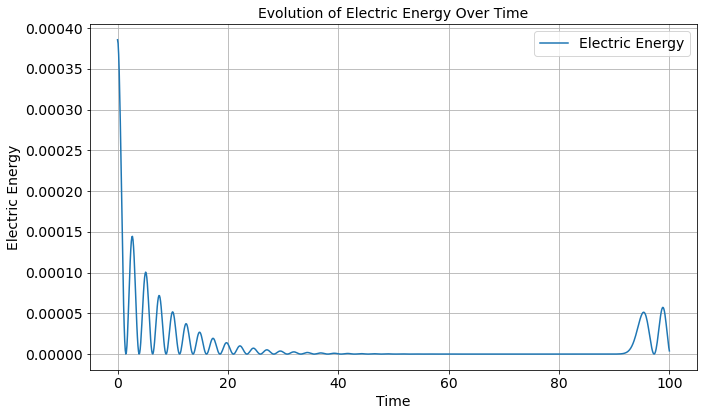

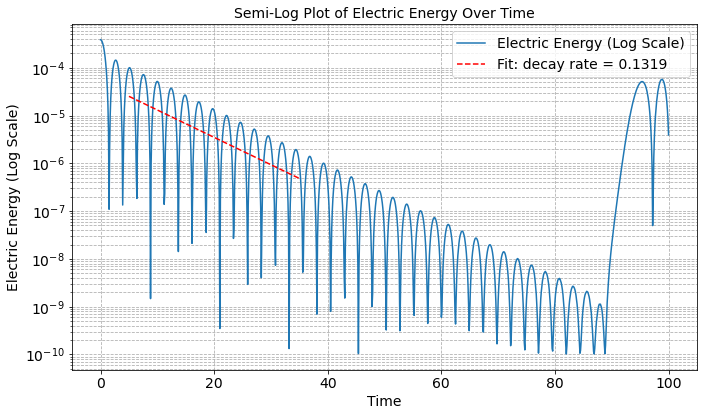

Estimated Landau damping rate for Electric Energy: 0.1319


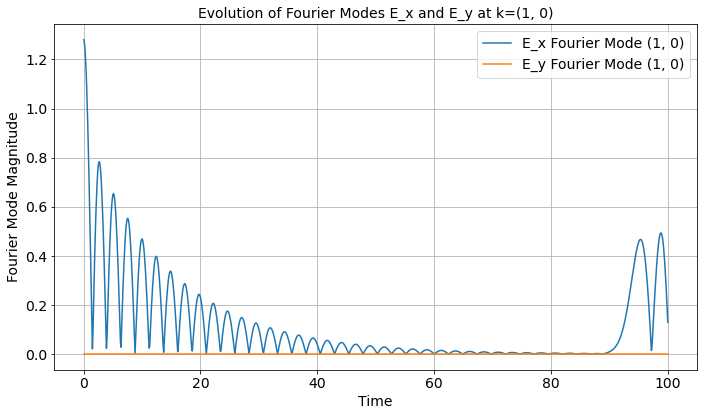

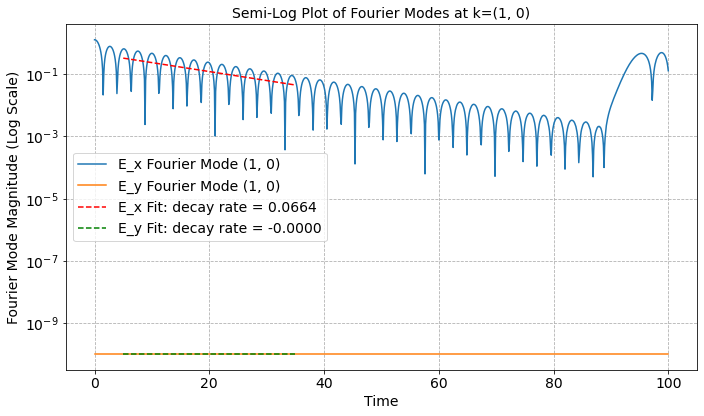

Estimated Landau damping rate for E_x Fourier Mode: 0.0664
Estimated Landau damping rate for E_y Fourier Mode: -0.0000


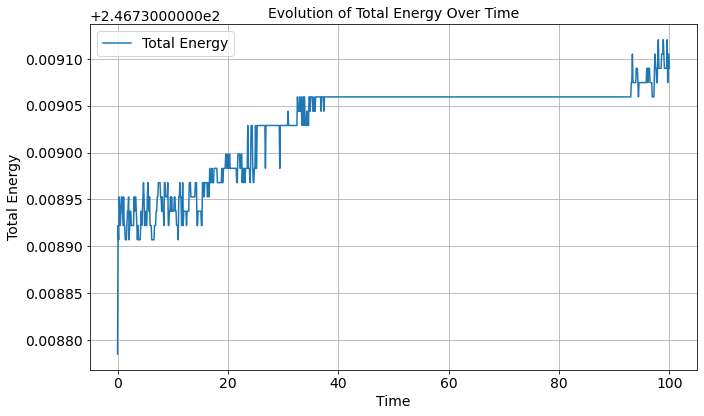

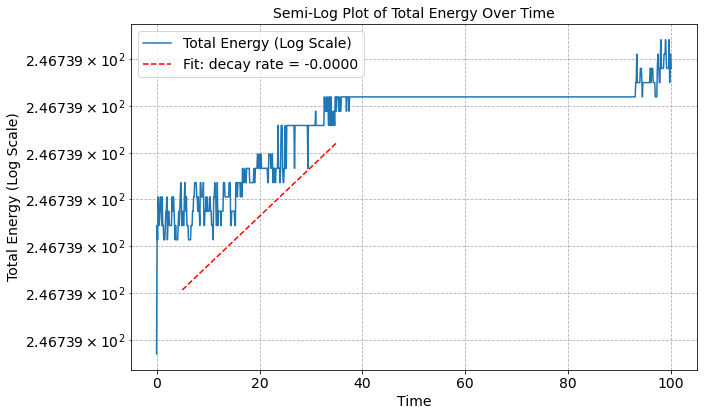

Estimated Landau damping rate for Total Energy: -0.0000


In [122]:
def linear_landau_damping():
    """
    Conducts the linear Landau damping experiment using the defined Vlasov-Poisson solver.

    The experiment initializes the distribution function with a small perturbation
    and observes the damping of electric fields and specific Fourier modes over time.
    It also computes and overlays the linear decay rates on semi-log plots for comparison.
    """
    # 1. **Define Simulation Parameters**
    k = 0.4  # Wave number (can be a float)
    alpha = 0.001  # Perturbation amplitude in x
    beta = 0.00   # Perturbation amplitude in y (no perturbation)
    domain_length = 2.0 * jnp.pi / k  # Domain length for x and y: [0, 2pi/k]
    N_x = 32  # Number of grid points in x
    N_y = 32  # Number of grid points in y
    N_vx = 64  # Number of grid points in v_x
    N_vy = 64  # Number of grid points in v_y
    Vx = 5.0  # Maximum velocity in x
    Vy = 5.0  # Maximum velocity in y
    delta_t = 0.1  # Time step
    N_steps = 1000  # Number of time steps
    k_track = (1, 0)  # Fourier mode to track (k, m)
    
    # Small epsilon to prevent log(0)
    epsilon = 1e-10
    
    # 2. **Generate Spatial and Velocity Grids**
    x = jnp.linspace(0.0, domain_length, N_x, endpoint=False)  # [0, 2pi/k)
    y = jnp.linspace(0.0, domain_length, N_y, endpoint=False)  # [0, 2pi/k)
    vx = jnp.linspace(-Vx, Vx, N_vx)
    vy = jnp.linspace(-Vy, Vy, N_vy)
    
    # Compute grid spacings
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dvx = vx[1] - vx[0]
    dvy = vy[1] - vy[0]
    
    # 3. **Create Meshgrids for Spatial and Velocity Coordinates**
    X, Y = jnp.meshgrid(x, y, indexing='ij')       # Shape: [N_x, N_y]
    VX, VY = jnp.meshgrid(vx, vy, indexing='ij')   # Shape: [N_vx, N_vy]
    
    # 4. **Initialize the Distribution Function f_iv**
    # Expand dimensions for broadcasting: [N_x, N_y, 1, 1]
    X_expanded = X[:, :, None, None]
    Y_expanded = Y[:, :, None, None]
    VX_expanded = VX[None, None, :, :]
    VY_expanded = VY[None, None, :, :]
    
    # Define the initial distribution function f_iv
    f_iv = (1 / (2 * jnp.pi)) * jnp.exp(-VX_expanded**2 / 2 - VY_expanded**2 / 2) \
           * (1 + alpha * jnp.cos(k * X_expanded) + beta * jnp.cos(k * Y_expanded))
    
    # 5. **Define External Electric Fields Hx and Hy**
    # Set Hx and Hy to zero (no external fields)
    Hx = jnp.zeros((N_x, N_y))  # External electric field in x-direction
    Hy = jnp.zeros((N_x, N_y))  # External electric field in y-direction
    
    # 6. **Run the Solver**
    # Execute the solver, passing Hx and Hy
    f_final, history_E, history_KE, history_EE, history_Fourier = run_solver(
        f_iv, grid_x=x, grid_y=y, grid_vx=vx, grid_vy=vy,
        delta_t=delta_t, N_steps=N_steps, k_track=k_track,
        Hx=Hx, Hy=Hy  # Pass external electric fields
    )
    
    # 7. **Convert JAX Arrays to NumPy for Plotting**
    history_E_np = np.array(history_E)        # Shape: [N_steps +1, N_x, N_y, 2]
    history_KE_np = np.array(history_KE)      # Shape: [N_steps +1]
    history_EE_np = np.array(history_EE)      # Shape: [N_steps +1]
    history_Fourier_np = np.array(history_Fourier)  # Shape: [N_steps +1, 2]
    
    # 8. **Define Time Array for Plotting**
    time_array = np.arange(N_steps + 1) * delta_t  # Shape: [N_steps +1]
    
    # 9. **Define Decay Rate Fitting Parameters**
    t_start = 5   # Start time for fitting (in units of simulation time)
    t_end = 35    # End time for fitting (in units of simulation time)
    
    # Convert t_start and t_end to indices
    idx_start = int(t_start / delta_t)
    idx_end = int(t_end / delta_t) + 1  # +1 to include t_end
    
    # 10. **Plot Evolution of Electric Energy**
    plt.figure(figsize=(10, 6))
    plt.plot(time_array, history_EE_np, label='Electric Energy')
    plt.xlabel('Time')
    plt.ylabel('Electric Energy')
    plt.title('Evolution of Electric Energy Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # **Add Semi-Log Plot for Electric Energy with Decay Rate**
    plt.figure(figsize=(10, 6))
    plt.semilogy(time_array, history_EE_np + epsilon, label='Electric Energy (Log Scale)')
    
    # Fit linear decay in log scale between t_start and t_end
    log_EE = np.log(history_EE_np[idx_start:idx_end] + epsilon)
    slope_EE, intercept_EE, _, _, _ = linregress(time_array[idx_start:idx_end], log_EE)
    decay_rate_EE = -slope_EE  # Damping rate
    
    # Generate fitted line
    fitted_EE = intercept_EE + slope_EE * time_array[idx_start:idx_end]
    plt.plot(time_array[idx_start:idx_end], np.exp(fitted_EE), 'r--',
             label=f'Fit: decay rate = {decay_rate_EE:.4f}')
    
    plt.xlabel('Time')
    plt.ylabel('Electric Energy (Log Scale)')
    plt.title('Semi-Log Plot of Electric Energy Over Time')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    
    print(f"Estimated Landau damping rate for Electric Energy: {decay_rate_EE:.4f}")
    
    # 11. **Plot Evolution of Tracked Fourier Modes**
    # Extract the tracked Fourier modes for E_x and E_y
    E_x_mode = history_Fourier_np[:, 0]  # Shape: [N_steps +1]
    E_y_mode = history_Fourier_np[:, 1]  # Shape: [N_steps +1]
    
    # Compute magnitudes (absolute values) of the Fourier modes
    E_x_modes_mag = np.abs(E_x_mode)
    E_y_modes_mag = np.abs(E_y_mode)
    
    # **Plot Fourier Modes Evolution (Original Scale)**
    plt.figure(figsize=(10, 6))
    plt.plot(time_array, E_x_modes_mag, label=f'E_x Fourier Mode {k_track}')
    plt.plot(time_array, E_y_modes_mag, label=f'E_y Fourier Mode {k_track}')
    plt.xlabel('Time')
    plt.ylabel('Fourier Mode Magnitude')
    plt.title(f'Evolution of Fourier Modes E_x and E_y at k={k_track}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # **Plot Fourier Modes Evolution (Semi-Log Scale) with Decay Rates**
    plt.figure(figsize=(10, 6))
    plt.semilogy(time_array, E_x_modes_mag + epsilon, label=f'E_x Fourier Mode {k_track}')
    plt.semilogy(time_array, E_y_modes_mag + epsilon, label=f'E_y Fourier Mode {k_track}')
    
    # Fit linear decay in log scale between t_start and t_end for E_x
    log_E_x = np.log(E_x_modes_mag[idx_start:idx_end] + epsilon)
    slope_E_x, intercept_E_x, _, _, _ = linregress(time_array[idx_start:idx_end], log_E_x)
    decay_rate_E_x = -slope_E_x  # Damping rate
    
    # Generate fitted line
    fitted_E_x = intercept_E_x + slope_E_x * time_array[idx_start:idx_end]
    plt.plot(time_array[idx_start:idx_end], np.exp(fitted_E_x), 'r--',
             label=f'E_x Fit: decay rate = {decay_rate_E_x:.4f}')
    
    # Fit linear decay in log scale between t_start and t_end for E_y
    log_E_y = np.log(E_y_modes_mag[idx_start:idx_end] + epsilon)
    slope_E_y, intercept_E_y, _, _, _ = linregress(time_array[idx_start:idx_end], log_E_y)
    decay_rate_E_y = -slope_E_y  # Damping rate
    
    # Generate fitted line
    fitted_E_y = intercept_E_y + slope_E_y * time_array[idx_start:idx_end]
    plt.plot(time_array[idx_start:idx_end], np.exp(fitted_E_y), 'g--',
             label=f'E_y Fit: decay rate = {decay_rate_E_y:.4f}')
    
    plt.xlabel('Time')
    plt.ylabel('Fourier Mode Magnitude (Log Scale)')
    plt.title(f'Semi-Log Plot of Fourier Modes at k={k_track}')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    
    print(f"Estimated Landau damping rate for E_x Fourier Mode: {decay_rate_E_x:.4f}")
    print(f"Estimated Landau damping rate for E_y Fourier Mode: {decay_rate_E_y:.4f}")
    
    # 12. **Plot Evolution of Total Energy**
    # Compute total energy as the sum of kinetic and electric energy
    total_energy_np = history_KE_np + history_EE_np  # Shape: [N_steps +1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_array, total_energy_np, label='Total Energy')
    plt.xlabel('Time')
    plt.ylabel('Total Energy')
    plt.title('Evolution of Total Energy Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # **Add Semi-Log Plot for Total Energy with Decay Rate**
    plt.figure(figsize=(10, 6))
    plt.semilogy(time_array, total_energy_np + epsilon, label='Total Energy (Log Scale)')
    
    # Fit linear decay in log scale between t_start and t_end
    log_total_energy = np.log(total_energy_np[idx_start:idx_end] + epsilon)
    slope_total, intercept_total, _, _, _ = linregress(time_array[idx_start:idx_end], log_total_energy)
    decay_rate_total = -slope_total  # Damping rate
    
    # Generate fitted line
    fitted_total_energy = intercept_total + slope_total * time_array[idx_start:idx_end]
    plt.plot(time_array[idx_start:idx_end], np.exp(fitted_total_energy), 'r--',
             label=f'Fit: decay rate = {decay_rate_total:.4f}')
    
    plt.xlabel('Time')
    plt.ylabel('Total Energy (Log Scale)')
    plt.title('Semi-Log Plot of Total Energy Over Time')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    
    print(f"Estimated Landau damping rate for Total Energy: {decay_rate_total:.4f}")
    

# Execute the experiment
if __name__ == "__main__":
    linear_landau_damping()
